In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from scipy import stats

In [ ]:
#Preparation, already finished

df_org = pd.read_excel('FinalVersion.xlsx')
snapshot = pd.read_excel('fund_snapshot_lux.xlsx')

cols = ['FundId', 'Month', 'Fund Size', 'Fund Flow', 'Fund Sustainability', 'CAPM Performance', 'Performance Three Factor', 'Performance Four Factor']
df = df_org[cols].replace({0:np.nan})

cols_snapshot = ['FundId', 'Inception Date', 'Equity Style Box (Long)']
snap = snapshot[cols_snapshot].replace({0:np.nan})

In [ ]:
#snap join into the summary, the ages are calculated according to the inception date
joint = df.join(snap.set_index('FundId'), on='FundId')
age = (joint['Inception Date'] - pd.to_datetime(2019-8-1))/np.timedelta64(1,'M')
joint['Age'] = age

fund_size_log = np.log10(joint['Fund Size'])
joint['size_log'] = fund_size_log

#the joint is saved and the column name Fund Sustainability is changed because of the space
#joint.to_excel("joint_snap.xlsx") 

In [2]:
joint = pd.read_excel('joint_snap.xlsx')

In [3]:
#convert the month column into correct form
joint['Month'] = pd.to_datetime(joint['Month'])
age = (joint['Month'] - joint['Inception Date'])/np.timedelta64(1,'M')
age = [int(i) for i in age]
joint['Age'] = age
#joint.dropna(subset=["esg_score"], inplace=True)

#convert the esb_l from string to float
esb_l = pd.DataFrame({'Equity Style Box (Long)':['Large Value', 'Large Growth', 'Large Blend', 'Mid Value', 'Mid Growth', 'Mid Blend','Small Value','Small Growth','Small Blend'], 'esb_l': [1, 2, 3, 4, 5, 6, 7, 8, 9]})
joint_new = joint.join(esb_l.set_index('Equity Style Box (Long)'), on='Equity Style Box (Long)')

#relative_flow is the size divided by flow value
flow = joint_new["Fund Flow"]
size = joint_new['Fund Size']
relative_flow = flow/size
joint_new['relative_flow'] = relative_flow

joint_new = joint_new.rename(columns={"Fund Sustainability": "esg_score"})

In [8]:
#build a new column, in which the esg_score is the value of next month
esg_ex = joint_new['esg_score']

esg_mod = [np.nan]*len(esg_ex)

for i in range(3276):
    for j in range(1,92):
         esg_mod[92*i+j-1] = esg_ex[92*i+j]
            
joint_new['esg_modified'] = esg_mod

In [ ]:
#calculate the vif
X = joint_new[['esg_score','Age','size_log']].dropna()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif

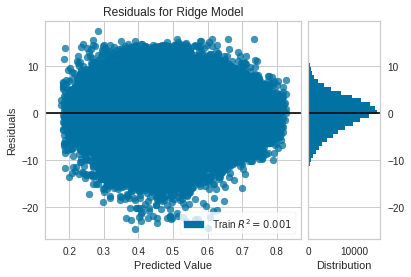

In [10]:
#residual with train and data set
data = joint_new[['esg_score','Age','size_log','capm_Performance', 'relative_flow']].dropna()

X = data[['esg_score','Age','size_log']]
y = data['capm_Performance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)
model = Ridge()

visualizer = ResidualsPlot(model)


visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
#visualizer.score(X_test, y_test)  # Evaluate the model on the test data
 
#visualizer.show()                 # Finalize and render the figure

visualizer.show(outpath="Residual.pdf")

In [11]:
#catagorize the month - 2012/01 to 2019/08, totoally 92 months
month = pd.Categorical(joint_new.Month)

#use the 'Month' to divide the dataset, the index is Fund ID
df = joint_new.set_index(['FundId', 'Month'])
df['Month'] = month

In [7]:
#capm Performance summary
exog_vars = ['esg_score','size_log', 'Age']
exog = sm.add_constant(df[exog_vars])
#ex represents t-1: last month
exog_vars_ex = ['esg_modified','size_log', 'Age']
exog_ex = sm.add_constant(df[exog_vars_ex])

mod = PanelOLS(df.capm_Performance, exog, entity_effects=True, time_effects=True)
mod_ex = PanelOLS(df.capm_Performance, exog_ex, entity_effects=True, time_effects=True)

res = mod.fit()
res_ex = mod_ex.fit()


#Performance three factor summary
exog_vars_tf = ['esg_score','size_log', 'Age']
exog_tf = sm.add_constant(df[exog_vars_tf])
#ex represents t-1: last month
exog_vars_ex_tf = ['esg_modified','size_log', 'Age']
exog_ex_tf = sm.add_constant(df[exog_vars_ex_tf])

mod_tf = PanelOLS(df.performance_Three_Factor, exog_tf, entity_effects=True, time_effects=True)
mod_ex_tf = PanelOLS(df.performance_Three_Factor, exog_ex_tf, entity_effects=True, time_effects=True)

res_tf = mod_tf.fit()
res_ex_tf = mod_ex_tf.fit()


#Performance four factor summary
exog_vars_ff = ['esg_score','size_log', 'Age']
exog_ff = sm.add_constant(df[exog_vars_ff])
#ex represents t-1: last month
exog_vars_ex_ff = ['esg_modified','size_log', 'Age']
exog_ex_ff = sm.add_constant(df[exog_vars_ex_ff])

mod_ff = PanelOLS(df.performance_Four_Factor, exog_ff, entity_effects=True, time_effects=True)
mod_ex_ff = PanelOLS(df.performance_Four_Factor, exog_ex_ff, entity_effects=True, time_effects=True)

res_ff = mod_ff.fit()
res_ex_ff = mod_ex_ff.fit()

/home/yuxuan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


KeyError: "['esg_modified'] not in index"

In [ ]:
#draw the plot of residual: x-axis is reconstructed y, y-axis is corresponfing residual
residual = data['capm_Performance'] - res.params[1]*data['esg_score'] - res.params[2]*data['size_log'] - res.params[3]*data['Age'] - res.params[0]
y_value = res.params[1]*data['esg_score'] + res.params[2]*data['size_log'] + res.params[3]*data['Age'] + res.params[0]
plt.cla()
plt.plot(y_value, residual, ".b")
plt.grid(True)
plt.title("Residual Plot CAPM Performance")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
#plt.pause(.5)
plt.savefig('ResPlot_CAPM_Performance.pdf')

In [ ]:
#Pearson correlation coefficient and p-value for testing non-correlation.
stats.pearsonr(data['esg_score'], data['capm_Performance'])
stats.pearsonr(data['esg_score'], data['size_log'])
stats.pearsonr(data['esg_score'], data['Age'])
stats.pearsonr(data['size_log'], data['capm_Performance'])
stats.pearsonr(data['Age'], data['capm_Performance'])
stats.pearsonr(data['Age'], data['size_log'])